Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 69s 7s/step - loss: 1525870.6250 - mae: 851.4119 - val_loss: 902367.7500 - val_mae: 606.8277
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 44s 5s/step - loss: 1060454.5000 - mae: 685.4055 - val_loss: 923853.3750 - val_mae: 751.5651
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 43s 5s/step - loss: 1061970.2500 - mae: 761.6313 - val_loss: 920241.0625 - val_mae: 722.1134
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 44s 5s/step - loss: 1030396.4375 - mae: 716.1959 - val_loss: 882992.0000 - val_mae: 796.5092
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 42s 5s/step - loss: 895637.3125 - mae: 701.3153 - val_loss: 785513.7500 - val_mae: 751.1072
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 45s 5s/step - loss: 837257.3125 - mae: 706.3365 - val_loss: 806616.7500 - val_mae: 754.6599
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 39s 4s/step - loss: 829520.1250 - mae: 701.3556 - val_loss: 864896.5000 - val_mae: 795.7383
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 39s 4s/step - loss: 762825.4375 - mae: 688.8432 


Validation MAE: 716.39 calories


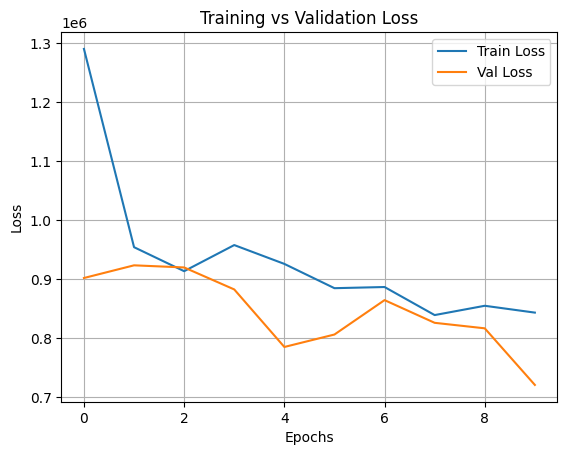

In [1]:
import os
import pandas as pd
import numpy as np
import cv2
import glob
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models     #deep learning models
import matplotlib.pyplot as plt

IMG_HEIGHT, IMG_WIDTH = 224, 224
BATCH_SIZE = 32
EPOCHS = 10

CSV_FILE = "E:/Jupyter/Prodigy/Task-4/archive/nutritionverse-manual/nutritionverse-manual/nutrition_manual.csv"     #excel sheet path
IMAGE_DIR = "E:/Jupyter/Prodigy/Task-4/archive/nutritionverse-manual/nutritionverse-manual/images"                  #images folder path

df = pd.read_csv(CSV_FILE)
df = df[['dish_id', 'total_calories']]
df.dropna(inplace=True)                                                     #delete rows with missing values
calorie_map = df.set_index('dish_id')['total_calories'].to_dict()

image_paths = []    #each images
calories = []       #calories predicted 

for img_path in glob.glob(os.path.join(IMAGE_DIR, '*.jpg')):
    filename = os.path.basename(img_path)
    try:
        parts = filename.split('_')
        if len(parts) >= 2:
            dish_id = int(parts[1])                             #file name is in format dish_1_....,dish_2_...
            if dish_id in calorie_map:                          #those 1,2 are the dish ids
                image_paths.append(img_path)
                calories.append(calorie_map[dish_id])
    except:
        continue

data = pd.DataFrame({'image_path': image_paths, 'calories': calories})
train_df, val_df = train_test_split(data, test_size=0.3, random_state=42)       #70% train 30%val

def generate_data(df):
    while True:
        for start in range(0, len(df), BATCH_SIZE):
            end = min(start + BATCH_SIZE, len(df))
            batch_df = df[start:end]
            images, labels = [], []
            for _, row in batch_df.iterrows():
                img = cv2.imread(row['image_path'])
                img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
                img = img / 255.0
                images.append(img)
                labels.append(row['calories'])
            yield np.array(images), np.array(labels)

model = models.Sequential([
    layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

train_steps = len(train_df) // BATCH_SIZE
val_steps = len(val_df) // BATCH_SIZE

history = model.fit(
    generate_data(train_df),
    steps_per_epoch=train_steps,
    epochs=EPOCHS,
    validation_data=generate_data(val_df),
    validation_steps=val_steps
)

val_imgs, val_labels = next(generate_data(val_df))
loss, mae = model.evaluate(val_imgs, val_labels)
print(f"\nValidation MAE: {mae:.2f} calories")

model.save('calorie_estimation_model.h5')

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step


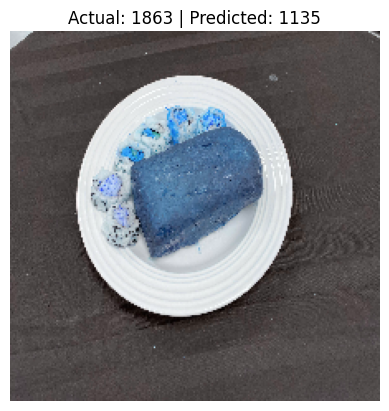

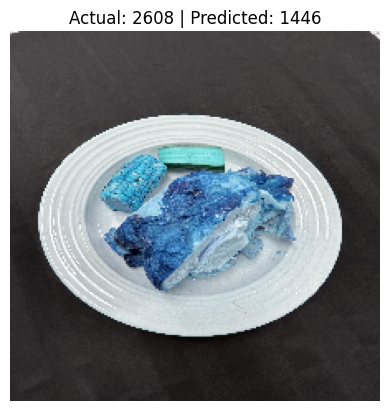

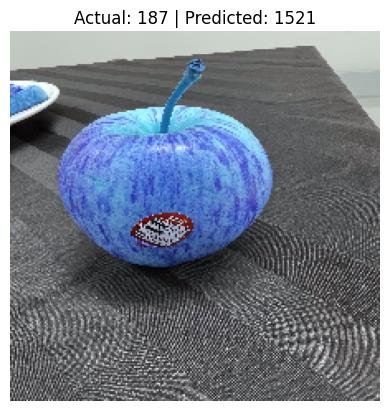

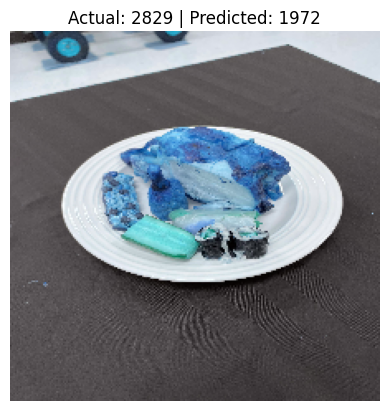

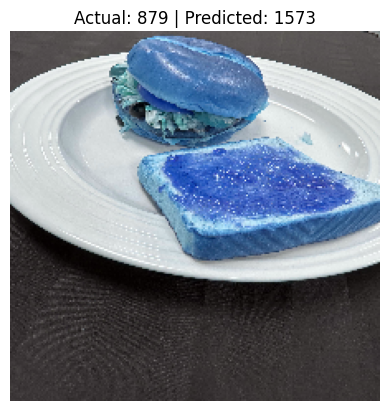

In [ ]:
sample_imgs, sample_labels = next(generate_data(val_df))
predictions = model.predict(sample_imgs)


for i in range(5): 
    plt.imshow(sample_imgs[i])
    plt.title(f"Actual: {sample_labels[i]:.0f} | Predicted: {predictions[i][0]:.0f}")
    plt.axis('off')
    plt.show()
